In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
df = pd.read_csv("./static/csv/car_price_prediction.csv")
print(df.head())
print(df.columns)

         ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
1   

### Предварительная обработка данных
Обработка пропущенных значений

In [46]:
# Очистка столбца 'Levy' от нечисловых значений
df['Levy'] = pd.to_numeric(df['Levy'], errors='coerce')
df['Levy'].fillna(df['Levy'].median(), inplace=True)


# Очистка столбца 'Mileage' от нечисловых значений
df['Mileage'] = df['Mileage'].str.replace(' km', '').astype(float)
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')

# Проверка типа данных в столбце 'Engine volume'
print(df['Engine volume'].dtype)

# Если столбец 'Engine volume' не является строковым, преобразуем его в строку
if df['Engine volume'].dtype != 'object':
    df['Engine volume'] = df['Engine volume'].astype(str)

# Очистка столбца 'Engine volume' от нечисловых значений
df['Engine volume'] = df['Engine volume'].str.replace(r'[^0-9.]', '', regex=True).astype(float)

# Заполнение пропущенных значений
df['Mileage'].fillna(df['Mileage'].median(), inplace=True)
df['Engine volume'].fillna(df['Engine volume'].median(), inplace=True)

df['Mileage'].fillna(df['Mileage'].mean(), inplace=True)

# Проверка на наличие NaN после заполнения
print("Пропущенные значения после заполнения:")
print(df.isnull().sum())

object
Пропущенные значения после заполнения:
ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


C:\Users\Egor\AppData\Local\Temp\ipykernel_21864\90121908.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Levy'].fillna(df['Levy'].median(), inplace=True)
C:\Users\Egor\AppData\Local\Temp\ipykernel_21864\90121908.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

Кодирование категориальных переменных

In [47]:
from sklearn.calibration import LabelEncoder

le = LabelEncoder()
categorical_cols = ['Manufacturer', 'Model', 'Category', 'Leather interior',
                    'Fuel type', 'Gear box type', 'Drive wheels', 'Doors',
                    'Wheel', 'Color']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

#### Масштабирование признаков
#### Понижение размерности - PCA
#### Визуализация PCA

Данные распределены вдоль оси X (Главный компонент 1) с некоторым разбросом вдоль оси Y (Главный компонент 2).

Большая часть дисперсии в данных объясняется первой главной компонентой.

Возможно, данные содержат несколько кластеров, которые можно идентифицировать с помощью кластерного анализа.

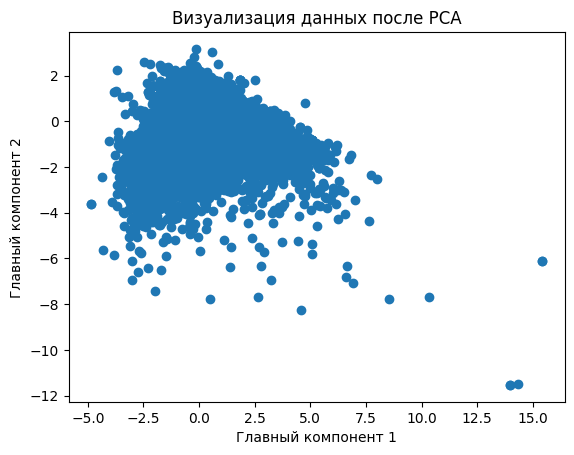

In [48]:
from pyexpat import features
from sklearn.decomposition import PCA

features = df.drop(['ID', 'Price'], axis=1)

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Проверка на наличие NaN после масштабирования
if np.isnan(X_scaled).any():
    raise ValueError("В масштабированных данных все еще присутствуют NaN.")

# Понижение размерности - PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Визуализация PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Главный компонент 1')
plt.ylabel('Главный компонент 2')
plt.title('Визуализация данных после PCA')
plt.show()


#### Выбор количества кластеров

#### График локтя

Инерция — это мера внутрикластерного рассеяния. Чем меньше инерция, тем более компактны и плотны кластеры.

Цель: Минимизировать инерцию, но при этом не создавать слишком много мелких кластеров.

Инерция резко падает при увеличении k от 2 до 3, а затем начинает выравниваться.

Локтевая точка находится при k = 3.

Оптимальное количество кластеров равно 3.

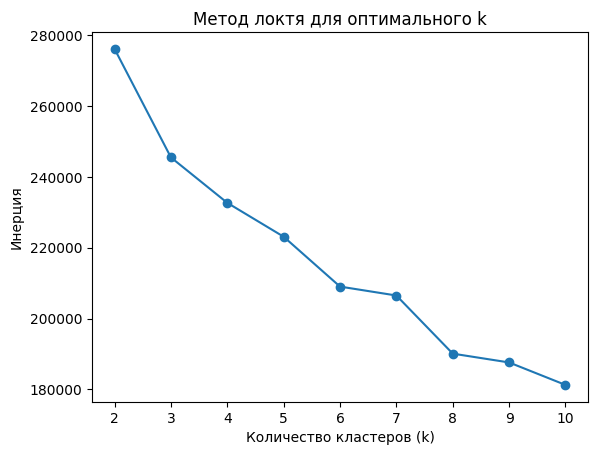

In [ ]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


inertia = []
silhouette = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')
plt.title('Метод локтя для оптимального k')
plt.show()

#### График силуэта

Коэффициент силуэта — это метрика, которая оценивает качество кластеризации. Он измеряет, насколько хорошо каждый объект в кластере подобен другим объектам в том же кластере (компактность) и насколько он отличается от объектов в других кластерах (разделение).

Значения: Коэффициент силуэта принимает значения от -1 до 1. Чем ближе значение к 1, тем лучше кластеризация. Значение 0 указывает на то, что кластеры пересекаются, а отрицательное значение указывает на неправильную кластеризацию.

Коэффициент силуэта достигает максимума при k = 2 и затем снижается при увеличении k.

Оптимальное количество кластеров равно 2.

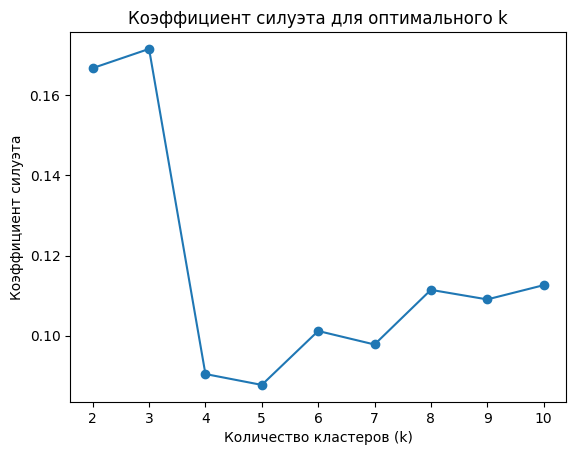

In [ ]:

plt.plot(range(2, 11), silhouette, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Коэффициент силуэта')
plt.title('Коэффициент силуэта для оптимального k')
plt.show()

#### Предположим, что оптимальное k равно 3 на основе графиков

#### Иерархическая кластеризация


#### K-Means кластеризация

#### Оценка качества кластеризации

Коэффициент силуэта — это метрика, которая оценивает качество кластеризации. Он измеряет, насколько хорошо каждый объект в кластере подобен другим объектам в том же кластере (компактность) и насколько он отличается от объектов в других кластерах (разделение).

Значения: Коэффициент силуэта принимает значения от -1 до 1. Чем ближе значение к 1, тем лучше кластеризация. Значение 0 указывает на то, что кластеры пересекаются, а отрицательное значение указывает на неправильную кластеризацию.

Индекс Дэвиса-Болдина — это метрика, которая оценивает качество кластеризации. Он измеряет отношение среднего расстояния между объектами в одном кластере к среднему расстоянию между объектами в разных кластерах.

Значения: Чем меньше значение индекса Дэвиса-Болдина, тем лучше кластеризация.

Коэффициент силуэта:
Иерархическая кластеризация: Коэффициент силуэта равен 0.133, что указывает на то, что кластеры имеют некоторую компактность, но не очень высокую.

K-Means кластеризация: Коэффициент силуэта равен 0.172, что немного выше, чем у иерархической кластеризации. Это указывает на то, что K-Means лучше справляется с созданием более компактных кластеров.

Индекс Дэвиса-Болдина:
Иерархическая кластеризация: Индекс Дэвиса-Болдина равен 2.509, что указывает на то, что кластеры имеют значительное пересечение.

K-Means кластеризация: Индекс Дэвиса-Болдина равен 2.234, что немного ниже, чем у иерархической кластеризации. Это указывает на то, что K-Means лучше справляется с разделением кластеров.

In [ ]:

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score


agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agg = agg_clustering.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)


silhouette_agg = silhouette_score(X_scaled, labels_agg)
davies_bouldin_agg = davies_bouldin_score(X_scaled, labels_agg)

silhouette_kmeans = silhouette_score(X_scaled, labels_kmeans)
davies_bouldin_kmeans = davies_bouldin_score(X_scaled, labels_kmeans)

print(f"Коэффициент силуэта (Agg): {silhouette_agg}")
print(f"Индекс Дэвиса-Болдина (Agg): {davies_bouldin_agg}")
print(f"Коэффициент силуэта (KMeans): {silhouette_kmeans}")
print(f"Индекс Дэвиса-Болдина (KMeans): {davies_bouldin_kmeans}")

Коэффициент силуэта (Agg): 0.13306117230156736
Индекс Дэвиса-Болдина (Agg): 2.5089898754817166
Коэффициент силуэта (KMeans): 0.17159548190302554
Индекс Дэвиса-Болдина (KMeans): 2.23429912220393


#### Визуализация кластеров

Главный компонент 1 (ось X): Это первая главная компонента, которая объясняет наибольшую дисперсию в данных.

Главный компонент 2 (ось Y): Это вторая главная компонента, которая объясняет следующую по величине дисперсию в данных.

Данные распределены вдоль оси X (Главный компонент 1) с некоторым разбросом вдоль оси Y (Главный компонент 2).

Большая часть дисперсии в данных объясняется первой главной компонентой.

На графике видны три кластера, которые расположены вдоль оси X.

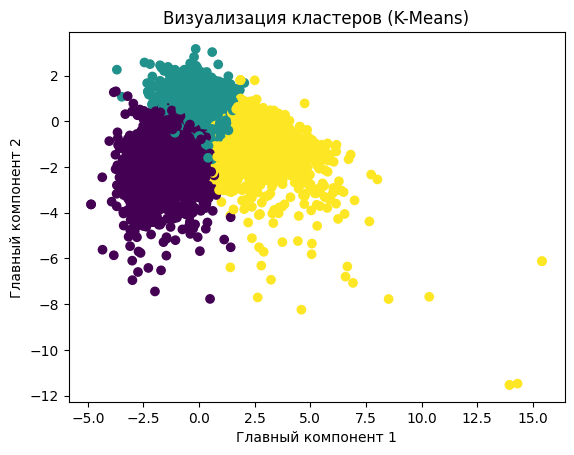

In [ ]:

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans)
plt.xlabel('Главный компонент 1')
plt.ylabel('Главный компонент 2')
plt.title('Визуализация кластеров (K-Means)')
plt.show()